In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter


Bad key "text.kerning_factor" on line 4 in
C:\ff\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

In [3]:
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [4]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [6]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweet.csv')

In [12]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
train.dropna(inplace=True)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [11]:
test.dropna(inplace=True)

In [14]:
sentiment_number = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
sentiment_number

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


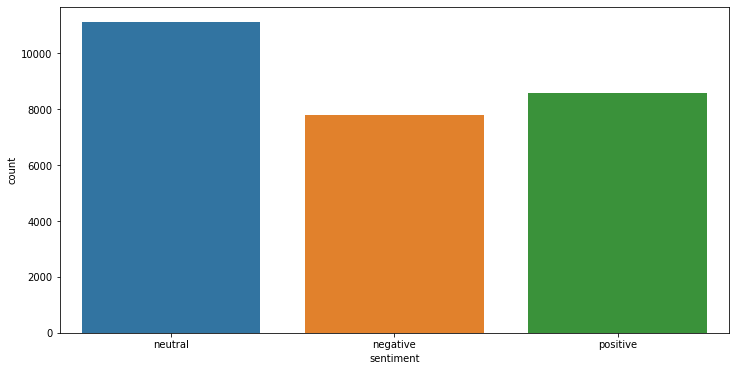

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [16]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [17]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [18]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [20]:
train['Num_words_selectxt'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_selectxt'] #Difference in Number of words text and Selected Text

In [21]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_selectxt,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [22]:
train[:30]

,textID,text,selected_text,sentiment,jaccard_score,Num_words_selectxt,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,12,12,0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,1,14,13
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.000000,2,2,0
8,e050245fbd,Both of you,Both of you,neutral,1.000000,3,3,0
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.500000,5,10,5


In [23]:
k = train[train['Num_word_text']<=2]
k.groupby('sentiment').mean()['jaccard_score']


sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [24]:
k[k['sentiment']=='positive']


,textID,text,selected_text,sentiment,jaccard_score,Num_words_selectxt,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


cleaning text

In [25]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [26]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [31]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
# Function to remove the stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Applying the stopwords to 'text_punct' and store into 'text_stop'
train["text"] = train["text"].apply(stopwords)
train["selected_text"] = train["selected_text"].apply(stopwords)

In [45]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,im,1676
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613


In [46]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

,Common_words,count
0,im,3020
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096


In [44]:
from collections import Counter
cnt = Counter()
for text in train["text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)


[('im', 3020),
 ('day', 2044),
 ('good', 1549),
 ('get', 1426),
 ('like', 1346),
 ('go', 1267),
 ('dont', 1200),
 ('love', 1122),
 ('work', 1112),
 ('going', 1096),
 ('today', 1096),
 ('got', 1072),
 ('cant', 1020),
 ('happy', 976),
 ('one', 971),
 ('lol', 948),
 ('time', 942),
 ('know', 930),
 ('u', 923),
 ('really', 908)]

In [34]:
from collections import Counter
cnt = Counter()
for text in train["selected_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('im', 1676),
 ('good', 1251),
 ('day', 1058),
 ('love', 909),
 ('happy', 852),
 ('like', 774),
 ('get', 772),
 ('dont', 765),
 ('go', 700),
 ('cant', 613),
 ('work', 612),
 ('going', 592),
 ('today', 564),
 ('got', 558),
 ('one', 538),
 ('time', 534),
 ('thanks', 532),
 ('lol', 528),
 ('really', 520),
 ('u', 519)]